In [43]:
import polars as pl
import spacy
from datasets import load_dataset
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
ds = load_dataset("Jsevisal/go_emotions_wheel")

In [19]:
df = pl.from_dicts(ds['train'][:])

In [ ]:
!python3 -m spacy download en_core_web_lg

In [20]:
nlp = spacy.load('en_core_web_lg')

In [21]:
docs = list(nlp.pipe(df.select('text').to_series().to_list()))

In [24]:
unigrams = [
    token.text.lower() for doc in docs for token in doc 
    if not token.is_stop and not token.is_punct and not token.is_space
]

unigram_counts = Counter(unigrams)

In [25]:
df_unigram_counts = pl.DataFrame(
    data = unigram_counts.most_common(10),
    schema = ['word', 'count'],
    orient = 'row'
)

In [26]:
# temp = df.select('text').to_series().to_list()
temp = df_unigram_counts.select('word').to_series().to_list()

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
tfidf = TfidfVectorizer()

In [29]:
res = tfidf.fit_transform(temp)

# Get idf values

**get_feature_names_out(input_features=None)**

Get output feature names for transformation.

In [30]:
temp_idf_values = [] 
for a, b in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    # print(f"{a} : {b}")
    temp_idf_values.append([a, b])

In [31]:
df_idf_values = pl.DataFrame(data = temp_idf_values, schema = ['a', 'b'], orient = 'row')

In [32]:
df_idf_values.head()

a,b
str,f64
"""good""",2.704748
"""got""",2.704748
"""know""",2.704748
"""like""",2.704748
"""lol""",2.704748


# get indexing


**vocabulary_** : *dict*:

A mapping of terms to feature indices.

In [33]:
temp_vocabulary = []
for v in tfidf.vocabulary_.keys():
    # print(tfidf.vocabulary_[v])
    temp_vocabulary.append([v, tfidf.vocabulary_[v]])

In [34]:
df_vocabulary = pl.DataFrame(data = temp_vocabulary, schema = ['word', 'index'], orient = 'row')

In [35]:
df_vocabulary.head()

word,index
str,i64
"""like""",3
"""love""",5
"""people""",6
"""good""",0
"""think""",8


# Display tf-idf values

In [36]:
print(res.toarray())

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [37]:
print(res)

  (np.int32(0), np.int32(3))	1.0
  (np.int32(1), np.int32(5))	1.0
  (np.int32(2), np.int32(6))	1.0
  (np.int32(3), np.int32(0))	1.0
  (np.int32(4), np.int32(8))	1.0
  (np.int32(5), np.int32(2))	1.0
  (np.int32(6), np.int32(7))	1.0
  (np.int32(7), np.int32(9))	1.0
  (np.int32(8), np.int32(4))	1.0
  (np.int32(9), np.int32(1))	1.0


# Matrix form

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(res.toarray())

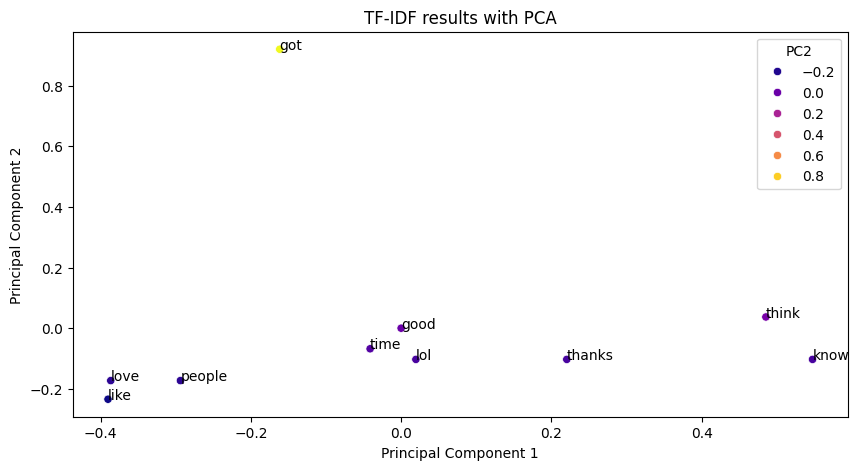

In [45]:
df_pca_result = pl.DataFrame(data = pca_result, schema = ['PC1', 'PC2'])
plt.figure(figsize=(10, 5))
ax =sns.scatterplot(data = df_pca_result, x = 'PC1', y = 'PC2', hue = 'PC2', palette = 'plasma')
for i, txt in enumerate(temp):
    plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('TF-IDF results with PCA')
plt.savefig('img/tfidf-pca.png', dpi = 400)
plt.show()

In [46]:
from sklearn.manifold import TSNE

In [47]:
tsne = TSNE(n_components=2, perplexity=2, random_state=0)
tsne_result = tsne.fit_transform(res.toarray())

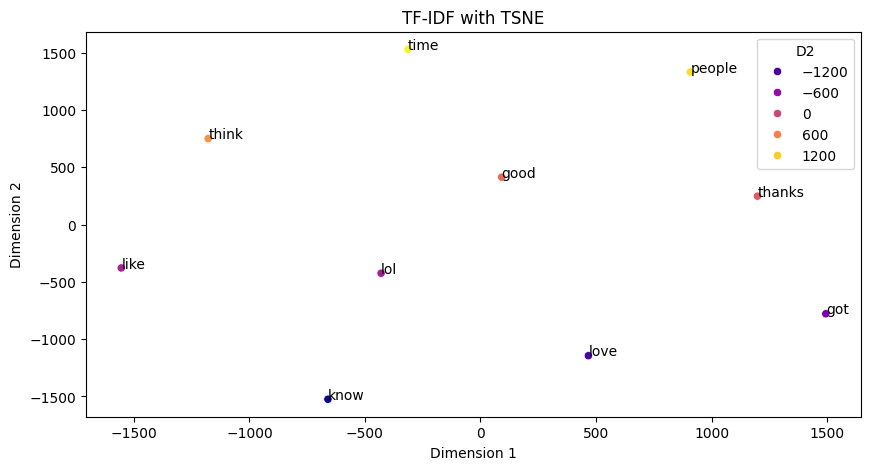

In [48]:
df_tsne_result = pl.DataFrame(data = tsne_result, schema = ['D1', 'D2'])
plt.figure(figsize = (10, 5))
ax= sns.scatterplot(data = df_tsne_result, x = 'D1', y = 'D2', hue = 'D2', palette = 'plasma')
for i, txt in enumerate(temp):
    plt.annotate(txt, (tsne_result[i, 0], tsne_result[i, 1]))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('TF-IDF with TSNE')
plt.savefig('img/tfidf-tsne.png', dpi = 400)
plt.show()